# Import packages

In [1]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from matplotlib.path import Path
import ot
import time
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

np.random.seed(0)

In [2]:
import sys
sys.path.append("../")

from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty

In [3]:
import torch
from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Generate Data

## House Data

In [4]:
points_per_axis = 8
lim = 0.25

x = np.linspace(-lim, lim, points_per_axis)
y = np.linspace(-lim, lim, points_per_axis)
X, Y = np.meshgrid(x, y)
square = np.array([X.ravel(), Y.ravel()]).T

vertex1 = np.array([-lim, lim])
vertex2 = np.array([lim, lim])
side_length = np.linalg.norm(vertex2 - vertex1)
height = (np.sqrt(3) / 2) * side_length
vertex3 = np.array([0, lim + height])

x_coords = []
y_coords = []

for i in range(points_per_axis):
    for j in range(points_per_axis - i):
        # Barycentric coordinates for the points
        t1 = i / points_per_axis
        t2 = j / points_per_axis
        t3 = 1 - t1 - t2

        # Calculate the position of each point using barycentric coordinates
        x = t1 * vertex1[0] + t2 * vertex2[0] + t3 * vertex3[0]
        y = t1 * vertex1[1] + t2 * vertex2[1] + t3 * vertex3[1]
        
        x_coords.append(x)
        y_coords.append(y)

points = np.array([x_coords, y_coords]).T
points.shape

# Concatenate points with square
house = np.concatenate([square, points], axis=0)

xmin, ymin = house.min(axis=0)
square -= np.array([xmin, ymin])
house -= np.array([xmin, ymin])

house.shape

(100, 2)

In [5]:
# Take random sample of 50 rows from the square matrix
n1 = 50
idx = np.random.choice(square.shape[0], n1, replace=False)
square_sample = square[idx]

# Concatenate sample with points to form a house
n2 = 25
idx = np.random.choice(points.shape[0], n2, replace=False)
house_sample = np.concatenate([square_sample, points[idx]], axis=0)

In [6]:
def generate_house_pair():
    width_dilation = np.random.uniform(0.5, 1.5)
    height_dilation = np.random.uniform(0.5, 1.5)
    triangle_dilation = np.random.uniform(0.5, 1.5)

    new_house = np.copy(house)
    new_house[:, 0] *= width_dilation
    new_house[:, 1] *= height_dilation

    triangle = new_house[points_per_axis**2:]
    xmin, ymin = np.min(triangle, axis=0)
    shift = np.array([xmin, ymin])
    triangle -= shift

    triangle[:, 1] *= triangle_dilation
    triangle += shift

    new_house[points_per_axis**2:] = triangle

    # Rotate new house by random theta
    theta = np.random.uniform(0, 2 * np.pi)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    new_house = np.dot(new_house, rotation_matrix)

    return new_house[:points_per_axis**2], new_house

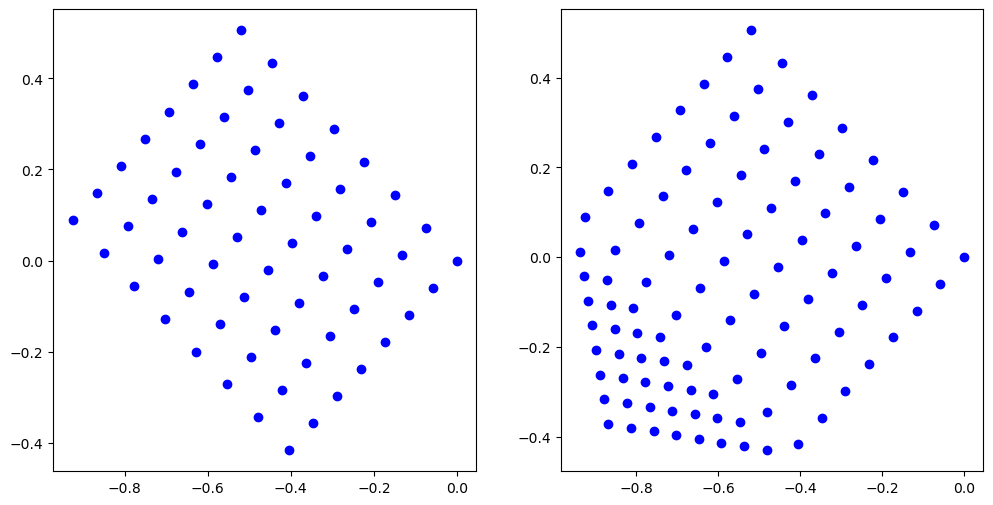

In [7]:
# 2 x 1 subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
new_square, new_house = generate_house_pair()

# Plot square
ax[0].scatter(new_square[:, 0], new_square[:, 1], color='blue', label='Square')

# Plot house
ax[1].scatter(new_house[:, 0], new_house[:, 1], color='blue', label='House')

In [8]:
square_samples = []
house_samples = []


for i in range(20):
    square_sample, house_sample = generate_house_pair()
    square_samples.append(square_sample)
    house_samples.append(house_sample)

# Arrows

In [9]:
arrow_shape = [[0, -0.1], [0, 0.1], [0.2, 0.1], [0.2, 0.3], [0.4, 0], [0.2, -0.3], [0.2, -0.1]]
points_per_axis = 16
vertices = np.array(arrow_shape)
    
# Generate barycentric coordinates
arrow_path = Path(arrow_shape)
    
# Generate a grid of points
x = np.linspace(-0.1, 0.5, points_per_axis)
y = np.linspace(-0.5, 0.5, points_per_axis)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.flatten(), Y.flatten())).T

# Filter points that are inside the arrow polygon
inside = arrow_path.contains_points(points)
x_coords, y_coords = points[inside, 0], points[inside, 1]

arrow = np.array([x_coords, y_coords]).T

xmin = arrow[:, 0].min()
arrow[:, 0] -= xmin - 0.6/points_per_axis

base_arrow = arrow[arrow[:, 0] <= 0.21]
point_arrow = arrow[arrow[:, 0] > 0.21]

arrow = np.concatenate([base_arrow, point_arrow, np.array([[0.4, 0]])], axis=0)
arrow.shape

(41, 2)

In [10]:
arrow2 = np.array([-x_coords, y_coords]).T
double_arrow = np.concatenate([arrow, arrow2], axis=0)

In [11]:
def generate_arrow_pair():
    width_dilation = np.random.uniform(0.5, 1.5)
    height_dilation = np.random.uniform(0.5, 1.5)
    triangle_dilation = np.random.uniform(1.0, 1.5)

    new_arrow = np.copy(arrow)
    new_arrow[:, 0] *= width_dilation
    new_arrow[:, 1] *= height_dilation

    
    new_arrow[base_arrow.shape[0]:, 1] *= triangle_dilation
    xvals = new_arrow[base_arrow.shape[0]:, 0]
    xdiffs = np.abs(xvals.reshape(1, -1) - xvals.reshape(-1, 1))
    shift = xdiffs.min()

    new_arrow[:, 0] -= np.min(new_arrow[:, 0]) - shift

    new_double_arrow = np.concatenate([new_arrow, np.array([-new_arrow[:, 0], new_arrow[:, 1]]).T], axis=0)

    # Rotate new arrow by random theta
    theta = np.random.uniform(0, 2 * np.pi)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    new_arrow = np.dot(new_arrow, rotation_matrix)
    new_double_arrow = np.dot(new_double_arrow, rotation_matrix)

    return new_arrow, new_double_arrow

(-0.5, 0.5)

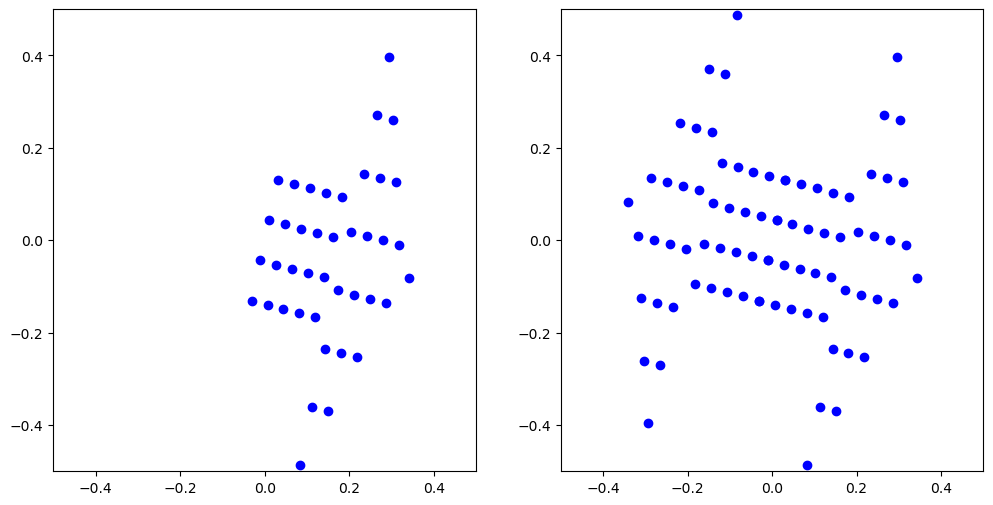

In [12]:
# 2 x 1 subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

new_arrow, new_double_arrow = generate_arrow_pair()

# Plot arrow
ax[0].scatter(new_arrow[:, 0], new_arrow[:, 1], color='blue', label='Square')
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylim(-0.5, 0.5)

# Plot double arrow
ax[1].scatter(new_double_arrow[:, 0], new_double_arrow[:, 1], color='blue', label='House')
ax[1].set_xlim(-0.5, 0.5)
ax[1].set_ylim(-0.5, 0.5)


In [13]:
arrow_samples = []
double_arrow_samples = []

for i in range(20):
    arrow_sample, double_arrow_sample = generate_arrow_pair()
    arrow_samples.append(arrow_sample)
    double_arrow_samples.append(double_arrow_sample)

# Circles

In [14]:
radius = 0.2
radial_divisions = 6
angular_divisions = 5 * radial_divisions

points = []
# Generate points for each radial division
for r in np.linspace(0, radius, radial_divisions):
    # Increasing the number of points with the radius
    num_points = int(angular_divisions * r / radius) if r != 0 else 1
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    for t in theta:
        points.append((r * np.cos(t), r * np.sin(t)))
circle = np.array(points)

circle.shape

(87, 2)

In [15]:
radius = 0.3
radial_divisions = 5
angular_divisions = 5 * radial_divisions

points = []
# Generate points for each radial division
for r in np.linspace(0, radius, radial_divisions):
    # Increasing the number of points with the radius
    num_points = int(angular_divisions * r / radius) if r != 0 else 1
    theta = np.linspace(-np.pi / 2, np.pi / 2, num_points, endpoint=False)
    for t in theta:
        points.append((r * np.cos(t), r * np.sin(t)))

semi_circle = np.array(points)

extra_points = np.logical_and(semi_circle[:, 0] <= 1e-3, semi_circle[:, 1] < 0)
extra_points = semi_circle[extra_points]
extra_points[:, 1] *= -1

semi_circle = np.concatenate([semi_circle, extra_points], axis=0)
semi_circle.shape

(66, 2)

In [16]:
circle_points = semi_circle[semi_circle[:, 0] > 1e-3]
circle_points[:, 0] *= -1
circle = np.concatenate([semi_circle, circle_points], axis=0)

In [17]:
def generate_circle_pair():
    width_dilation = np.random.uniform(0.5, 1.5)
    height_dilation = np.random.uniform(0.5, 1.5)

    new_circle = np.copy(circle)
    new_circle[:, 0] *= width_dilation
    new_circle[:, 1] *= height_dilation

    new_semi_circle = new_circle[new_circle[:, 0] >= 0]

    # Rotate new circle by random theta
    theta = np.random.uniform(0, 2 * np.pi)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    new_semi_circle = np.dot(new_semi_circle, rotation_matrix)
    new_circle = np.dot(new_circle, rotation_matrix)

    return new_semi_circle, new_circle

(-0.5, 0.5)

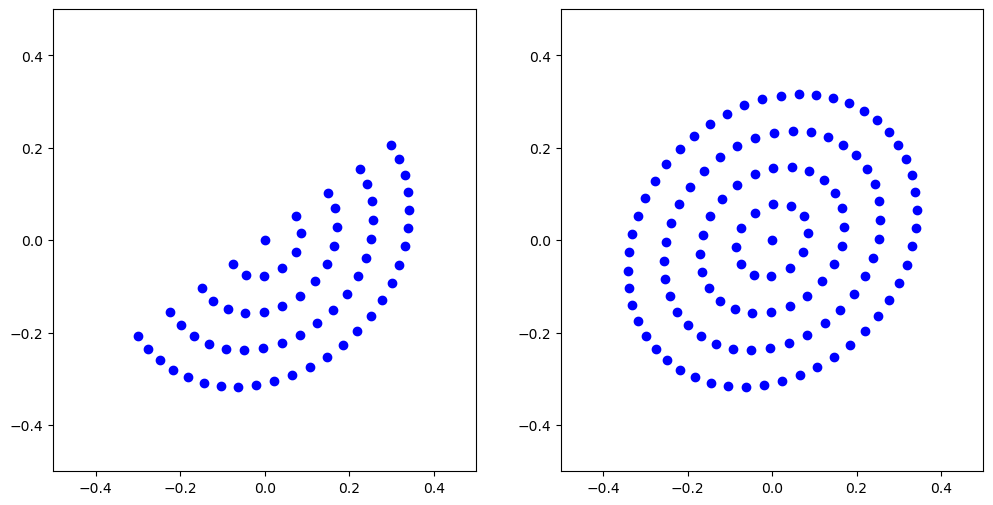

In [18]:
# 2 x 1 subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

new_semi_circle, new_circle = generate_circle_pair()

# Plot arrow
ax[0].scatter(new_semi_circle[:, 0], new_semi_circle[:, 1], color='blue', label='Square')
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylim(-0.5, 0.5)

# Plot double arrow
ax[1].scatter(new_circle[:, 0], new_circle[:, 1], color='blue', label='House')
ax[1].set_xlim(-0.5, 0.5)
ax[1].set_ylim(-0.5, 0.5)

In [19]:
semi_circle_samples = []
circle_samples = []

for i in range(20):
    new_semi_circle, new_circle = generate_circle_pair()
    semi_circle_samples.append(new_semi_circle)
    circle_samples.append(new_circle)

In [20]:
posns = square_samples + house_samples + arrow_samples + double_arrow_samples + semi_circle_samples + circle_samples
np.savez('synthetic_data.npz', *posns)

120